# 22 E lenta single cell analysis

## Objective
To demostrate the strain resolution of EASi-seq, the mixture of 22 E lenta strains were processed with EASi-seq workflow. The library are sequenced on illumina platform. 

## Data processing
1. Build reference genomes bowtie2 index
2. Raw sequencing data processing (Filter by barcode counts, Barcode extraction/demultiplex, and Splitting by barcodes)
3. Map individual barcodes to the reference genomes (bowtie2 with '-a')
4. Estimate the abundance of strains in each barcode group
5. Data visulization


### list of the 22 strains

```
GCA_000185625.1	Scaffold	ACWN00000000.1	SAMN02463797	1356FAA	Eggerthella lenta	
GCA_003339875.1	Contig	PPTU00000000	SAMN08365984	W1 BHI 6	Eggerthella lenta	
GCA_003339885.1	Contig	PPTV00000000	SAMN08365983	Valencia	Eggerthella lenta	
GCA_003339915.1	Contig	PPTW00000000	SAMN08365982	RC4/6F	Eggerthella lenta	
GCA_003339945.1	Scaffold	PPTZ00000000	SAMN08365979	UCSF2243	Eggerthella lenta	
GCA_003340005.1	Contig	PPUB00000000	SAMN08365977	DSM 15644	Eggerthella lenta	
GCA_003340015.1	Scaffold	PPUC00000000	SAMN08365976	DSM 11863	Eggerthella lenta	
GCA_003340045.1	Contig	PPUD00000000	SAMN08365975	DSM 11767	Eggerthella lenta	
GCA_003340065.1	Contig	PPUE00000000	SAMN08365974	CC8/6 D5 4	Eggerthella lenta	
GCA_003340075.1	Scaffold	PPUF00000000	SAMN08365973	CC8/2 BHI2	Eggerthella lenta	
GCA_003340125.1	Contig	PPUL00000000	SAMN08365967	A2	Eggerthella lenta	
GCA_003340145.1	Contig	PPUJ00000000	SAMN08365969	AB8 #2	Eggerthella lenta	
GCA_003340155.1	Contig	PPUI00000000	SAMN08365970	AN51LG	Eggerthella lenta	
GCA_003340165.1	Contig	PPUN00000000	SAMN08365965	28B	Eggerthella lenta	
GCA_003340195.1	Scaffold	PPUO00000000	SAMN08365964	22C	Eggerthella lenta	
GCA_003340245.1	Contig	PPUS00000000	SAMN08365960	11C	Eggerthella lenta	
GCA_003340255.1	Contig	PPUR00000000	SAMN08365961	14A	Eggerthella lenta	
GCA_003340395.1	Contig	PPTY00000000	SAMN08365980	FAA1-1-60AUCSF	Eggerthella lenta	
GCA_003340405.1	Contig	PPUG00000000	SAMN08365972	CC7/5 D5 2	Eggerthella lenta	
GCA_003340445.1	Scaffold	PPUK00000000	SAMN08365968	AB12 #2	Eggerthella lenta	
GCA_003340465.1	Contig	PPUM00000000	SAMN08365966	32-6-I 6 NA	Eggerthella lenta	
GCA_003339935.1	Scaffold	PPTX00000000	SAMN08365981	MR1 #12	Eggerthella lenta	

```
### Reference genome prepare

Reference genome of the 22 E lenta strains are downloaded from NCBI and saved in folder:
./reference/elenta/
```
EL-11C.fna EL-14A.fna EL-28B.fna EL-A2.fna EL-AB8-2.fna EL-cc7-5d52.fna EL-cc86d54.fna EL-DSM11863.fna EL-FAA1160aucsf.fna EL-RC46F.fna EL-Valencia.fna EL-1356FAA.fna EL-22c.fna EL-326i6na.fna EL-AB12-2.fna EL-An51lg.fna EL-cc82bhi2.fna EL-DSM11767.fna EL-DSM15644.fna EL-MR1-12.fna EL-UCSF2243.fna EL-W1BHI6.fna
```

In [3]:
# extract all the contig headers associated with each genome  
!ls *.fna | parallel "grep '>' {} | sed 's/>//g' | cut -f 1 -d ' '  > {.}.txt" # save all headers of each reference genome in a txt file
!ls *.txt > EL22_contig.list # save the file names of all the contig header files in a list 

In [1]:
import pandas as pd
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
wk_dir = './reference/elenta/'
contig_files = pd.read_csv(wk_dir + 'EL22_contig.list', names =['files']).files.tolist()

In [112]:

strain_contig = {}# make a dictionary: strains as keys and contigs as values 
contig_strain = {}# make a dictionary: contig as keys and strain as values 
for f in contig_files:
    strain = f.split('.')[0]
    contigs = pd.read_csv(wk_dir + f, names =['contigs']).contigs.tolist()
    strain_contig[strain]= contigs
    for contig in contigs:
        contig_strain[contig]=strain
strain_contig['none'] = ['none'] 
contig_strain['none']='none'
# because the m_alpha files from estimateVBExpression has a contig 'none'

In [ ]:
# Build refence genome with combined fasta files
!cat ./reference/elenta/*.fna > ./reference/elenta/combined_EL22.fna # combine all fasta files
!bowtie2-build --threads 2  combined_EL22.fna ./reference/elenta/bt2/El22 # make bowtie2 index 

## FASTQ file processing

E lenta EASi-seq library was sequenced on Illumina Novaseq platform by Novogene.
Data saved in folder: ./raw_data/

```
./raw_data/ElentaA/ElentaA_CKDL210003375-1a-AK405-N501_HVFLWDSXY_L4_1.fq.gz
./raw_data/ElentaA/ElentaA_CKDL210003375-1a-AK405-N501_HVFLWDSXY_L4_2.fq.gz
./raw_data/ElentaB/ElentaB_CKDL210003375-1a-AK406-N502_HVFLWDSXY_L4_1.fq.gz
./raw_data/ElentaB/ElentaB_CKDL210003375-1a-AK406-N502_HVFLWDSXY_L4_2.fq.gz

```

### Barcode extraction 
Run mb_barcode_and_trim command to extract the barcode from raw sequencing data FASTQ files

##### Step 1: Barcode extraction

#run the following code in the command line

In [ ]:
!mkdir ./splited/elenta/
!python2 ./missionbio-tools/mb_barcode_and_trim_scwga.py Elenta ./raw_data/ElentaA/ ./splited/elenta/ --chem_version V2 --r1_min_len 30 --r2_min_len 30 --min_reads 5000

#this command generate the following documents:
1. the barcode extracted fastq files: "Elenta_R1.fastq.gz", "Elenta_R1.fastq.gz"

The barcode sequence has been writen to the header in each entry, shown as following. 
```
@A00738:212:HVFLWDSXY:4:1101:6406:1031_TGACCTCCTAGCAAGTCC-1
CGTTCATGTTCTGGGCGAAGTGGCTGGGCAAGCTTTCCGGCATCGCCGCTCGTCCCGAGAACGTCGAGGCCAAGGTGCATT
+
FFFFF,:FFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,FFFFF:FFFFFFFFFFFFFF
```
2. A CSV file of read counts in each barcode group: "Elenta_barcode_counts.tsv"                                     

##### Step 2: Filter the barcodes by read counts 

In [ ]:
# analysis filenames
exp_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/elenta/'
tsv_path = exp_dir + 'Elenta_barcode_counts.tsv'
output_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/analysis/'


In [9]:
# extract barcodes and read totals
all_df = pd.read_csv(tsv_path, sep='\t', index_col=0)

barcodes_all = list(all_df.index)
reads_per_cell = [int(i) for i in list(all_df.sum(axis=1))]

total_reads = sum(reads_per_cell)

reads_per_cell, barcodes_all = (list(t) for t in zip(*sorted(zip(reads_per_cell, barcodes_all), reverse=True)))

print('%d total barcoded reads in experiment' % total_reads)

105896184 total barcoded reads in experiment


Text(0, 0.5, 'Reads per Cell')

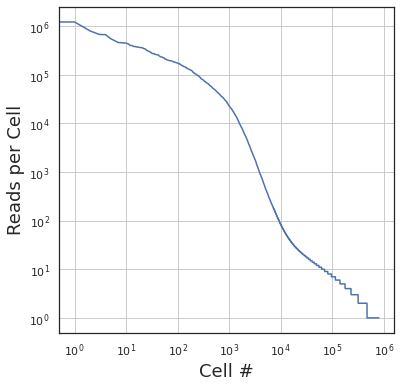

In [13]:
# plot log-log reads per cell vs cells
plt.figure(figsize=(6, 6))
ax = plt.axes()
ax.grid()
plt.loglog(range(len(reads_per_cell)), reads_per_cell, color='b')
plt.xlabel('Cell #', fontsize=18)
plt.ylabel('Reads per Cell', fontsize=18)

In [15]:
# set minimum number of reads per cell
min_reads = 100
# create dataframe for called cells only
min_reads_df = all_df.loc[(all_df.sum(axis=1) >= min_reads), :]
valid_barcodes = list(min_reads_df.index)

# print stats
print('%d cells called' % len(min_reads_df.index))
frac_cells = min_reads_df.values.sum()/total_reads
print('Fraction of reads belonging to valid cells: %0.4f' % frac_cells)

9291 cells called
Fraction of reads belonging to valid cells: 0.9711


In [16]:
with open(exp_dir + "valid_barcodes.txt", "w") as f:
    for bar in valid_barcodes:
        f.write(bar +"\n")
        
#valide barcodes saved in file valid_barcodes.txt

##### Step 3: Demultiplex by barcode 
Demultiplex by the barcode sequences give in the "valid_barcodes.txt" using the demuxbyname.sh from BBTools 

In [ ]:
!demuxbyname.sh prefixmode=f -Xmx20g length=20 in1=Elenta_R1.fastq.gz in2=Elenta_R2.fastq.gz out1=./splited/elenta/scFASTQ/fq/%_R1.fq out2=./splited/elenta/scFASTQ/fq/%_R2.fq names=valid_barcodes.txt
#seperated files for each barcodes are generated in the folder ./splited/elenta/scFASTQ/fq/

##### Step 4: Map to references


In [ ]:
!for sample in `ls ./splited/elenta/scFASTQ/fq/*_R2.fq`; do dir="./splited/elenta/scFASTQ"; base=$(basename $sample "_R2.fq"); (bowtie2 -p 56 -a  -x ./reference/elenta/bt2/El22 -1 ${dir}/fq/${base}_R1.fq  -2 ${dir}/fq/${base}_R2.fq | samtools view -bS - > ${dir}/sam/${base}.bam ) 2>${dir}/sam/${base}.log; done
#It is worth nating '-a' is used in the bowtie2 command to save all possible alignment, which is required for abundance estimation. 
#The alignment files are saved as individual bam files.
#The log of each alignments are saved as individual log files. 
! ls ./splited/elenta/scFASTQ/sam/*.log > ./splited/elenta/scFASTQ/sam/all_logs.list
#Save all the files names as a list for future use

##### Step 5: Barcode filtering by alignment rate

In [ ]:
cov_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/elenta/scFASTQ/sam/'
log_files = cov_dir + 'all_logs.list'

output_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/elenta/scFASTQ/analysis/'

In [39]:
bar_oar_readcnt = pd.DataFrame(columns=['Barcode', 'overall mapping rate','Read Count']) 
# make a new dataframe of barcode groups' overall alignment rate and read count
for l in map_rate_list: # Cycle throught the alignment log files and extract the alignment rate and read counts values
    bar = l.split('.')[0] # barcode sequences, such as 'AACAACCTAAGTGTGCAC-2'
    
    log = open(cov_dir + l, 'r') # read the log files
    lines = log.readlines()
    log.close()
    
    oar = float(lines[-1].split('%')[0]) # overall alignment rate
    cnt = float(lines[0].split(' ')[0]) # read counts
   
    bar_oar_readcnt.loc[len(bar_oar_readcnt.index)] = [bar, oar, cnt] # add new line to the dataframe
bar_oar_readcnt = bar_oar_readcnt.set_index('Barcode')

In [54]:
bar_oar_readcnt.to_csv(output_dir+'Elenta_Easi-seq_bar_alignment-rate_read-cnt.csv')

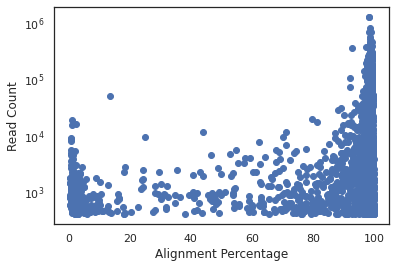

In [43]:
plt.scatter(bar_oar_readcnt['overall mapping rate'], bar_oar_readcnt['Read Count'])
#plt.title('Barcode group to reference genome alignment rage')
plt.ylabel('Read Count')
#plt.yscale('log')
plt.xlabel('Alignment Percentage')
plt.yscale("log")
plt.show()

In [55]:
## filter the barcode groups by the alignment rate to the references.
min_map_rate = 10 # the minimum alignment 

In [57]:
## filtere the data by minimum alignment 
bar_oar_readcnt_filtered = bar_oar_readcnt[bar_oar_readcnt['overall mapping rate']>=min_map_rate]
## save the data
bar_oar_readcnt_filtered.to_csv(output_dir+'Elenta_Easi-seq_bar_alignment-rate_read-cnt_filtered.csv')

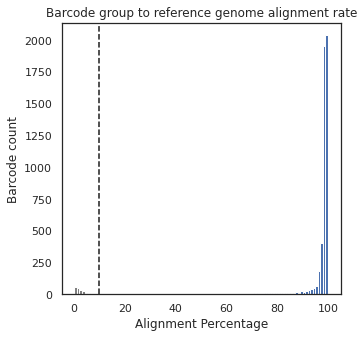

In [52]:
## plot the filtering process
fig, ax = plt.subplots(figsize=(5,5))
N,bins, patches = ax.hist(bar_oar_readcnt['overall mapping rate'], bins =100)
plt.axvline(x=min_map_rate, color='k', linestyle='--', label='mapping rate Threshold')
for i in range(0,min_map_rate):
    patches[i].set_facecolor('grey')
for i in range(min_map_rate,100):    
    patches[i].set_facecolor('b')
plt.title('Barcode group to reference genome alignment rate')
plt.ylabel('Barcode count')
#plt.yscale('log')
plt.xlabel('Alignment Percentage')
plt.savefig(output_dir + 'filter_by_alignment_rate_elenta.pdf',bbox_inches='tight')

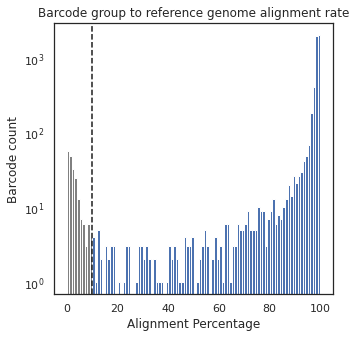

In [53]:
## plot the filtering process (log scale)
fig, ax = plt.subplots(figsize=(5,5))
N,bins, patches = ax.hist(bar_oar_readcnt['overall mapping rate'], bins =100)
plt.axvline(x=min_map_rate, color='k', linestyle='--', label='mapping rate Threshold')
for i in range(0,min_map_rate):
    patches[i].set_facecolor('grey')
for i in range(min_map_rate,100):    
    patches[i].set_facecolor('b')
plt.title('Barcode group to reference genome alignment rate')
plt.ylabel('Barcode count')
plt.yscale('log')
plt.xlabel('Alignment Percentage')
plt.savefig(output_dir + 'filter_by_alignment_rate_elenta_log.pdf',bbox_inches='tight')

##### Step 6: Estimate the strain abundance in each barcode group (DESeq2)


###### 6.1  use parseAlignment to calculate probabilities of alignments
Run the following in command line in the folder: './splited/elenta/scFASTQ/sam/'
```
ls *.bam | parallel 'parseAlignment {} -o {.}.prob --trSeqFile ./reference/elenta/combined_EL22.fna --trInfoFile {.}.tr --uniform -P 32 --verbose' 
```
###### 6.2  use estimateVBExpression to calculate the abundance of each contig
Run the following in command line
```
ls *.tr | parallel 'estimateVBExpression -o {.} --trInfoFile {}  {.}.prob' 
```

###### 6.4 Extract the contig names from *.tr file

In [60]:
alphas_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/elenta/scFASTQ/sam/'

In [73]:
# the tr file contains 4 columns, the sencond column is the contig name, which is needed for the analysis
# since all tr file contain the same info. use the first barcode's tr file to extract the information.  
tr_file = alphas_dir + '{}.tr'.format(bar_oar_readcnt_filtered.index.tolist()[0]) # choose the first barcode tr file
tr_ls = pd.read_csv(tr_file, names =['none','contigs', 'length', 'total'],sep = ' ', comment = '#')['contigs'].tolist()
tr_ls.append('none') # in the m_alphas file, the last row is the percentage of reads that map to no reference genome. use 'none' for the last row.

###### 6.5 Combine the m_alphas files at strain level

In [88]:
alphas = alphas_dir + 'all_full_m_alphas.list' # this is the file lists.
filtered_bars = bar_oar_readcnt_filtered.index.to_list()

In [134]:
strains = list(strain_contig.keys()) # the list of the 22 E. lenta strains, plus 'none' to repersent not aligned to any strain. 
# initialize the dataframes
df_strain_esti =pd.DataFrame(index= strains) #strain abundance estimation

df_contig_esti = pd.DataFrame(index = tr_ls) #contig anundance estimation


for bar in filtered_bars:
    file = alphas_dir + bar + '.m_alphas'
    m_alpha_df  =  pd.read_csv(file, sep = ' ', comment='#', names = [bar, 'alpha', 'beta']).drop(['alpha','beta'], axis =1)
    m_alpha_df['tr'] = tr_ls 
    m_alpha_df['strain']=m_alpha_df.tr.map(contig_strain)
    m_alpha_df = m_alpha_df.set_index('tr')
    strain_df = m_alpha_df.groupby('strain').sum()
    df_strain_esti = pd.concat([df_strain_esti,strain_df],axis=1 )
    df_contig_esti = pd.concat([df_contig_esti,m_alpha_df[bar]], axis=1)

In [135]:
#save the combined files
df_strain_esti.T.to_csv(output_dir + 'Elenta_EASi_seq_bar_strain_abundance_estimation_filtered.csv')
df_contig_esti.T.to_csv(output_dir + 'Elenta_EASi_seq_bar_contig_abundance_estimation_filtered.csv')

EL-11C  EL-1356FAA    EL-14A    EL-22c    EL-28B  \
AACAACCTAAGTGTGCAC-2  0.054738    0.015804  0.045878  0.029382  0.041667   
AACAACCTACCGAGTACT-2  0.006799    0.001882  0.014137  0.004232  0.006714   
AACAACCTATAGGTTAGT-1  0.070487    0.003619  0.013354  0.014046  0.012083   
AACAACCTATATCCTCAG-1  0.038864    0.012702  0.198568  0.021908  0.028577   
AACAACTGGAGCTTCGAT-2  0.080300    0.001779  0.030323  0.003487  0.010901   

                      EL-326i6na     EL-A2  EL-AB12-2  EL-AB8-2  EL-An51lg  \
AACAACCTAAGTGTGCAC-2    0.043842  0.028804   0.040354  0.035233   0.047023   
AACAACCTACCGAGTACT-2    0.007550  0.023620   0.276491  0.023932   0.017545   
AACAACCTATAGGTTAGT-1    0.012411  0.005748   0.026608  0.008572   0.011222   
AACAACCTATATCCTCAG-1    0.031185  0.027239   0.029162  0.025121   0.029159   
AACAACTGGAGCTTCGAT-2    0.014216  0.002522   0.029695  0.014343   0.008633   

                      ...  EL-DSM11767  EL-DSM11863  EL-DSM15644  \
AACAACCTAAGTGTGCAC-2  ...     0.054247     0.062563     0.061165   
AACAACCTACCGAGTACT-2  ...     0.014805     0.019868     0.007559   
AACAACCTATAGGTTAGT-1  ...     0.104323     0.034556     0.060523   
AACAACCTATATCCTCAG-1  ...     0.038727     0.049409     0.041474   
AACAACTGGAGCTTCGAT-2  ...     0.011160     0.028542     0.029781   

                      EL-FAA1160aucsf  EL-MR1-12  EL-RC46F  EL-UCSF2243  \
AACAACCTAAGTGTGCAC-2         0.106210   0.032459  0.037284     0.047040   
AACAACCTACCGAGTACT-2         0.011340   0.004942  0.006742     0.022167   
AACAACCTATAGGTTAGT-1         0.135779   0.091781  0.157720     0.058370   
AACAACCTATATCCTCAG-1         0.189308   0.024480  0.025664     0.039932   
AACAACTGGAGCTTCGAT-2         0.048014   0.014475  0.004686     0.011388   

                      EL-Valencia  EL-W1BHI6      none  
AACAACCTAAGTGTGCAC-2     0.062244   0.034195  0.000549  
AACAACCTACCGAGTACT-2     0.019943   0.003526  0.000145  
AACAACCTATAGGTTAGT-1     0.128502   0.021495  0.000123  
AACAACCTATATCCTCAG-1     0.038171   0.030821  0.000441  
AACAACTGGAGCTTCGAT-2     0.636003   0.003897  0.000054  

[5 rows x 23 columns]

##### Step 7: Strain annotation 

In [31]:

df_strain_esti = pd.read_csv(output_dir + 'Elenta_EASi_seq_bar_strain_abundance_estimation_filtered.csv', index_col=0)
df_strain_esti = df_strain_esti.drop(columns = ['none'])
column_ls = df_strain_esti.columns.tolist()

In [32]:
df_strain_esti['max']= df_strain_esti[column_ls].max(axis=1)
df_strain_esti['average']= df_strain_esti[column_ls].mean(axis=1)
df_strain_esti['std']=  df_strain_esti[column_ls].std(axis=1)
df_strain_esti['max_z']=  (df_strain_esti['max']-df_strain_esti['average'])/df_strain_esti['std']


In [33]:
df_strain_esti['species']=  df_strain_esti[column_ls].idxmax(axis=1)
min_z=3.1 # alpha level = 0.001
df_strain_esti.loc[df_strain_esti['max_z']<min_z, 'species']='mix'
bar_strain_dict = df_strain_esti.species.to_dict()

In [34]:
df_strain_esti.to_csv(output_dir + 'Elenta_EASi_seq_bar_strain_abundance_estimation_filtered_use_z_test_to_annotate.csv')

In [35]:
df_strain_esti.head()

EL-11C  EL-1356FAA    EL-14A    EL-22c    EL-28B  \
AACAACCTAAGTGTGCAC-2  0.054738    0.015804  0.045878  0.029382  0.041667   
AACAACCTACCGAGTACT-2  0.006799    0.001882  0.014137  0.004232  0.006714   
AACAACCTATAGGTTAGT-1  0.070487    0.003619  0.013354  0.014046  0.012083   
AACAACCTATATCCTCAG-1  0.038864    0.012702  0.198568  0.021908  0.028577   
AACAACTGGAGCTTCGAT-2  0.080300    0.001779  0.030323  0.003487  0.010901   

                      EL-326i6na     EL-A2  EL-AB12-2  EL-AB8-2  EL-An51lg  \
AACAACCTAAGTGTGCAC-2    0.043842  0.028804   0.040354  0.035233   0.047023   
AACAACCTACCGAGTACT-2    0.007550  0.023620   0.276491  0.023932   0.017545   
AACAACCTATAGGTTAGT-1    0.012411  0.005748   0.026608  0.008572   0.011222   
AACAACCTATATCCTCAG-1    0.031185  0.027239   0.029162  0.025121   0.029159   
AACAACTGGAGCTTCGAT-2    0.014216  0.002522   0.029695  0.014343   0.008633   

                      ...  EL-MR1-12  EL-RC46F  EL-UCSF2243  EL-Valencia  \
AACAACCTAAGTGTGCAC-2  ...   0.032459  0.037284     0.047040     0.062244   
AACAACCTACCGAGTACT-2  ...   0.004942  0.006742     0.022167     0.019943   
AACAACCTATAGGTTAGT-1  ...   0.091781  0.157720     0.058370     0.128502   
AACAACCTATATCCTCAG-1  ...   0.024480  0.025664     0.039932     0.038171   
AACAACTGGAGCTTCGAT-2  ...   0.014475  0.004686     0.011388     0.636003   

                      EL-W1BHI6       max   average       std     max_z  \
AACAACCTAAGTGTGCAC-2   0.034195  0.106210  0.045430  0.017998  3.377081   
AACAACCTACCGAGTACT-2   0.003526  0.472664  0.045448  0.110964  3.850045   
AACAACCTATAGGTTAGT-1   0.021495  0.157720  0.045449  0.048456  2.316974   
AACAACCTATATCCTCAG-1   0.030821  0.198568  0.045435  0.048734  3.142242   
AACAACTGGAGCTTCGAT-2   0.003897  0.636003  0.045452  0.133187  4.433993   

                              species  
AACAACCTAAGTGTGCAC-2  EL-FAA1160aucsf  
AACAACCTACCGAGTACT-2      EL-cc7-5d52  
AACAACCTATAGGTTAGT-1              mix  
AACAACCTATATCCTCAG-1           EL-14A  
AACAACTGGAGCTTCGAT-2      EL-Valencia  

[5 rows x 27 columns]

###### Pairplot

In [36]:
cells = column_ls
cells.append('mix')
colors = ['#a6cee3',
         '#1f78b4',
         '#b2df8a',
         '#33a02c',
         '#fb9a99',
         '#e31a1c',
         '#fdbf6f',
         '#ff7f00',
         '#cab2d6',
         '#6a3d9a',
         '#ffff99',
         '#b15928',
         'tan',
          'lightcoral',
          'gold',
          'lime',
          'olive',
          'greenyellow',
          'aqua',
          'crimson',
          'lightseagreen',
          'plum',
          'tab:grey',
          'seagreen',
                    ] 
print(len(colors))
cell_color_table = dict(zip(cells,colors))


24


In [23]:
cells

['EL-11C',
 'EL-1356FAA',
 'EL-14A',
 'EL-22c',
 'EL-28B',
 'EL-326i6na',
 'EL-A2',
 'EL-AB12-2',
 'EL-AB8-2',
 'EL-An51lg',
 'EL-cc7-5d52',
 'EL-cc82bhi2',
 'EL-cc86d54',
 'EL-DSM11767',
 'EL-DSM11863',
 'EL-DSM15644',
 'EL-FAA1160aucsf',
 'EL-MR1-12',
 'EL-RC46F',
 'EL-UCSF2243',
 'EL-Valencia',
 'EL-W1BHI6',
 'mix']

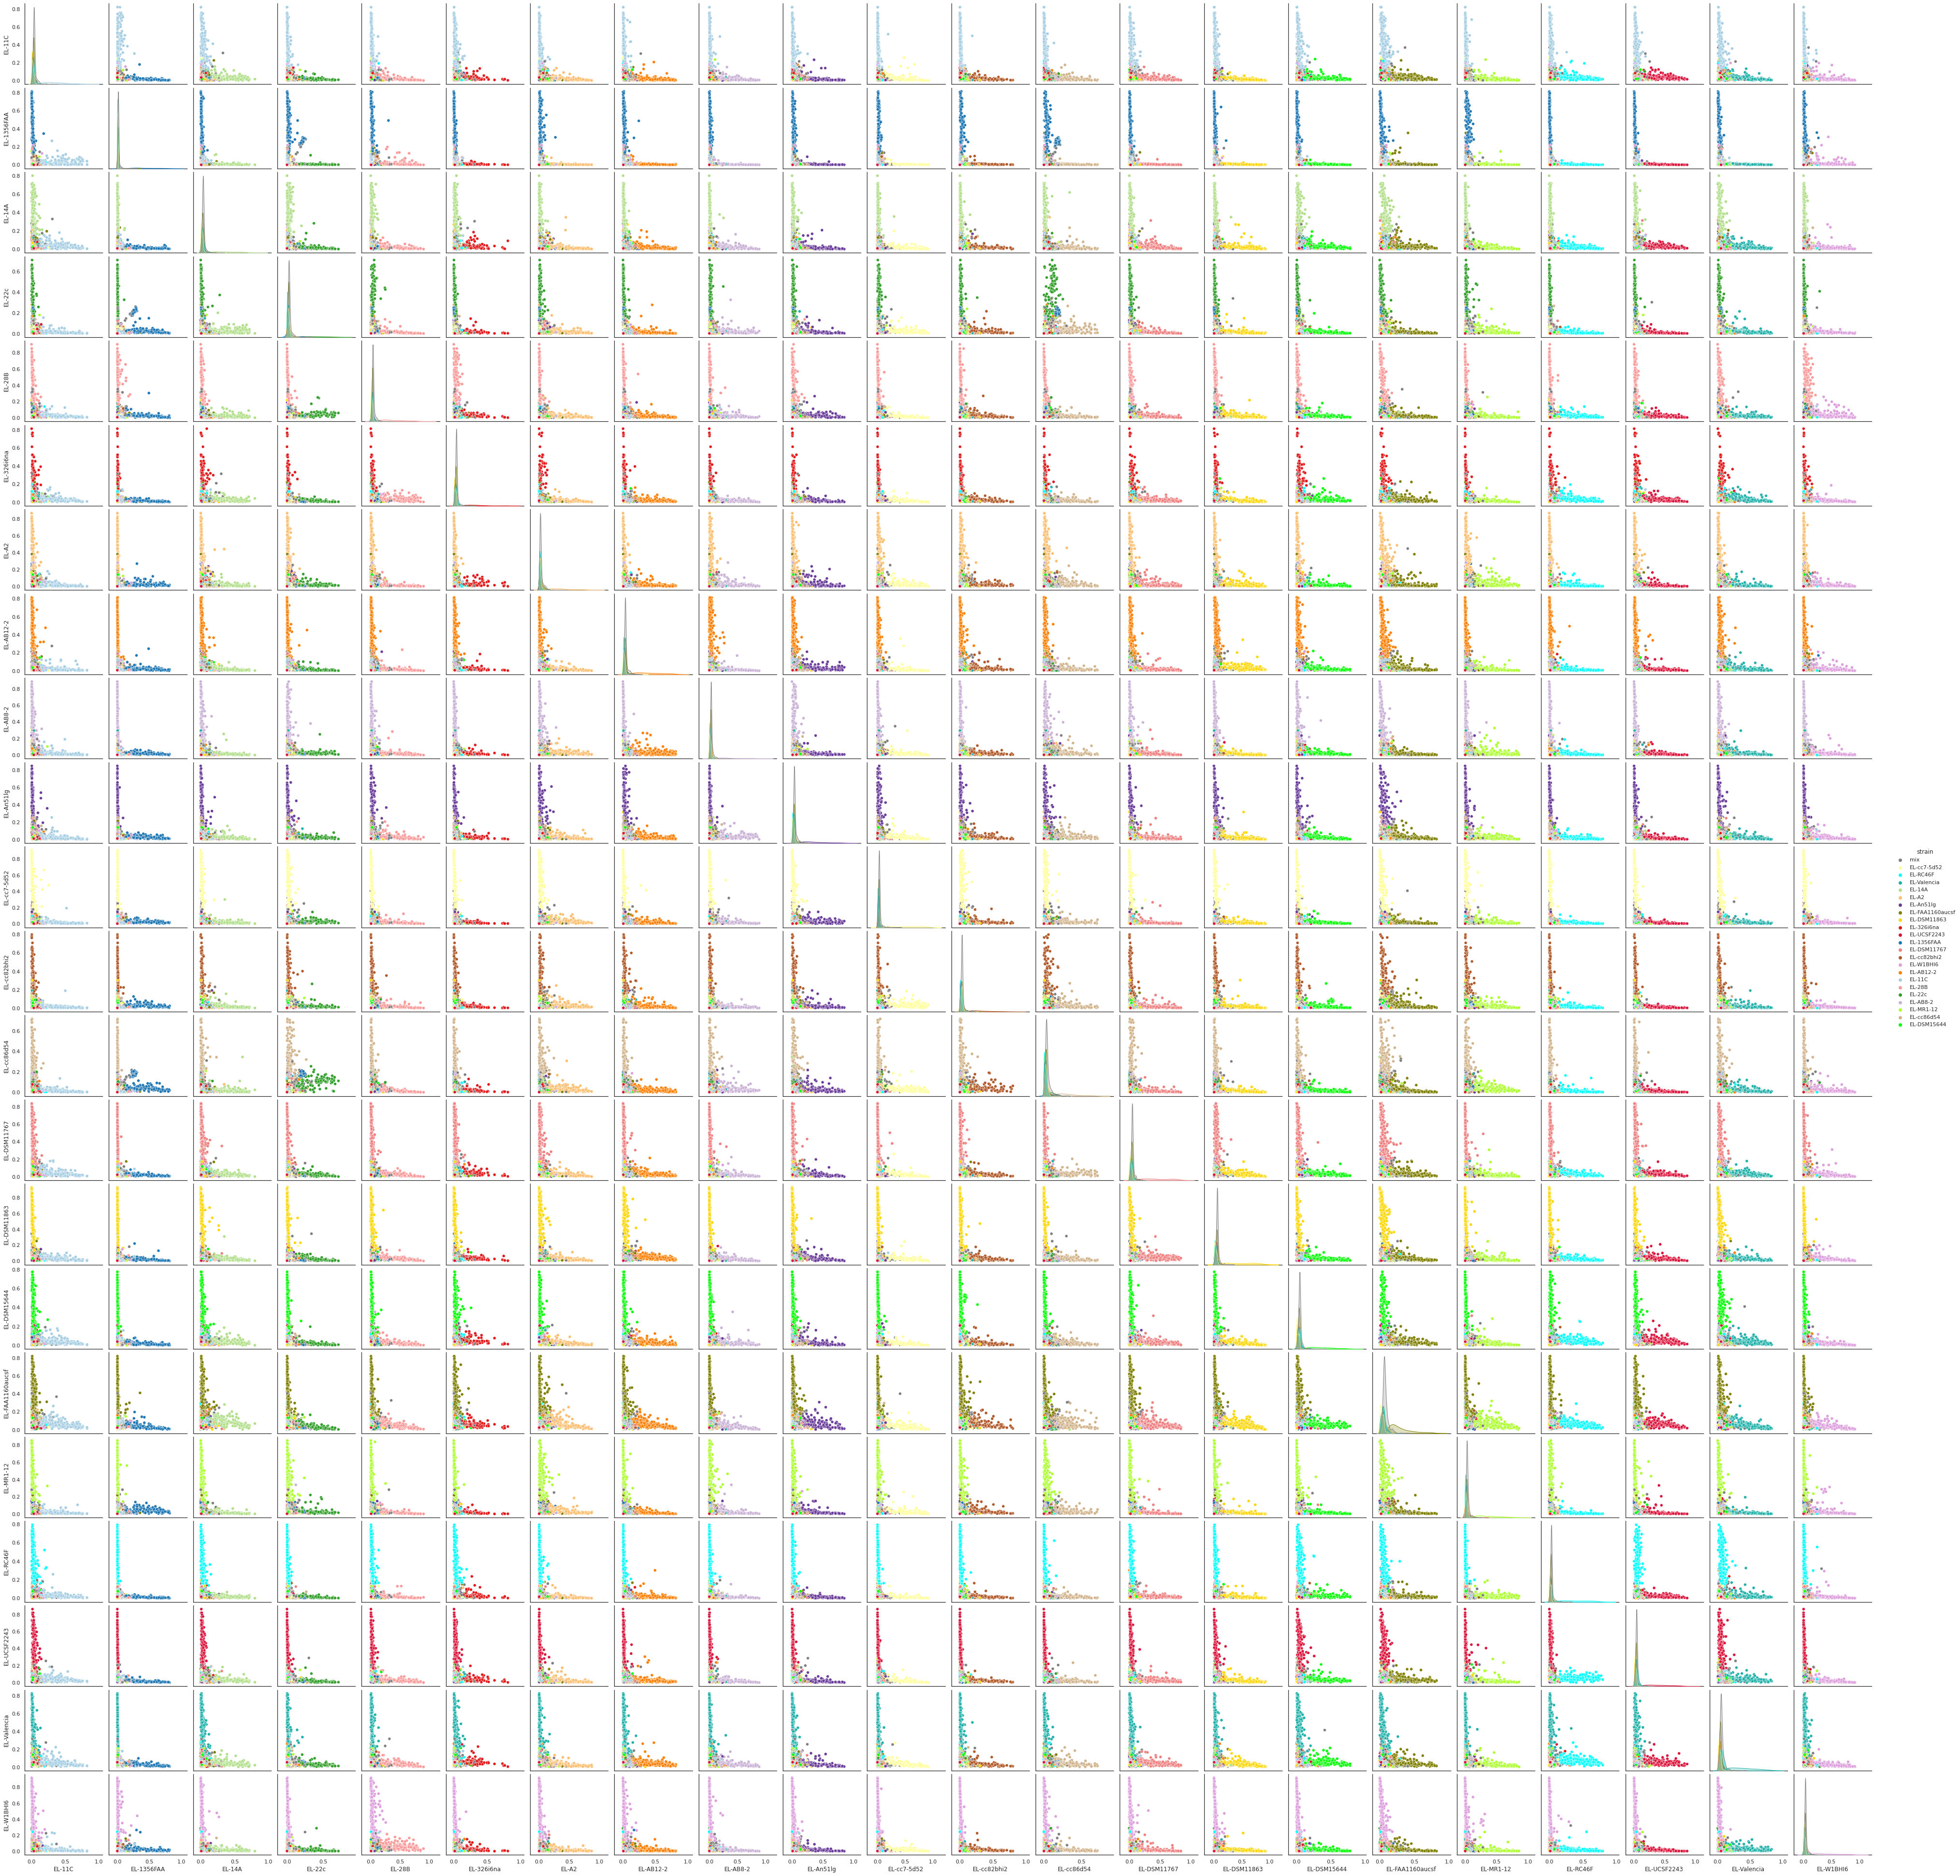

In [179]:
sns.pairplot(df_strain_esti.drop(columns=['max','average','std','max_z'],axis=1), 
             #diag_kind="kde", 
             hue = 'species',
             palette =cell_color_table,
            )
plt.savefig(output_dir+'Elenta_easi_seq_bar_strain_abd_esti_filtered_pairplot_color_coded.png')
plt.savefig(output_dir+'Elenta_easi_seq_bar_strain_abd_esti_filtered_pairplot_color_coded.pdf')
plt.savefig(output_dir+'Elenta_easi_seq_bar_strain_abd_esti_filtered_pairplot_color_coded.svg')

##### Step 8: UMAP visulization

In [29]:
import scanpy as sc
import anndata

In [30]:
df_strain_esti

EL-11C  EL-1356FAA    EL-14A    EL-22c    EL-28B  \
AACAACCTAAGTGTGCAC-2  0.054738    0.015804  0.045878  0.029382  0.041667   
AACAACCTACCGAGTACT-2  0.006799    0.001882  0.014137  0.004232  0.006714   
AACAACCTATAGGTTAGT-1  0.070487    0.003619  0.013354  0.014046  0.012083   
AACAACCTATATCCTCAG-1  0.038864    0.012702  0.198568  0.021908  0.028577   
AACAACTGGAGCTTCGAT-2  0.080300    0.001779  0.030323  0.003487  0.010901   
...                        ...         ...       ...       ...       ...   
TTGTCAACCGAGTTAACT-2  0.020898    0.008870  0.028772  0.016810  0.020278   
TTGTTAGAGACAGCGGTC-2  0.017653    0.007886  0.018409  0.012217  0.023667   
TTGTTAGAGATCTAGGTT-2  0.051243    0.007223  0.274489  0.013157  0.026309   
TTGTTAGAGCACGACTCA-1  0.162909    0.015501  0.034953  0.027627  0.034851   
TTGTTAGAGGGATACCTA-2  0.034567    0.000628  0.009682  0.001185  0.007847   

                      EL-326i6na     EL-A2  EL-AB12-2  EL-AB8-2  EL-An51lg  \
AACAACCTAAGTGTGCAC-2    0.043842  0.028804   0.040354  0.035233   0.047023   
AACAACCTACCGAGTACT-2    0.007550  0.023620   0.276491  0.023932   0.017545   
AACAACCTATAGGTTAGT-1    0.012411  0.005748   0.026608  0.008572   0.011222   
AACAACCTATATCCTCAG-1    0.031185  0.027239   0.029162  0.025121   0.029159   
AACAACTGGAGCTTCGAT-2    0.014216  0.002522   0.029695  0.014343   0.008633   
...                          ...       ...        ...       ...        ...   
TTGTCAACCGAGTTAACT-2    0.025756  0.140905   0.019999  0.018010   0.022415   
TTGTTAGAGACAGCGGTC-2    0.042888  0.016246   0.035712  0.014490   0.138786   
TTGTTAGAGATCTAGGTT-2    0.042009  0.067212   0.020347  0.015126   0.017285   
TTGTTAGAGCACGACTCA-1    0.039509  0.018734   0.033403  0.031377   0.034391   
TTGTTAGAGGGATACCTA-2    0.017462  0.002499   0.006994  0.004008   0.010799   

                      ...  EL-cc86d54  EL-DSM11767  EL-DSM11863  EL-DSM15644  \
AACAACCTAAGTGTGCAC-2  ...    0.034901     0.054247     0.062563     0.061165   
AACAACCTACCGAGTACT-2  ...    0.013623     0.014805     0.019868     0.007559   
AACAACCTATAGGTTAGT-1  ...    0.013331     0.104323     0.034556     0.060523   
AACAACCTATATCCTCAG-1  ...    0.027508     0.038727     0.049409     0.041474   
AACAACTGGAGCTTCGAT-2  ...    0.004610     0.011160     0.028542     0.029781   
...                   ...         ...          ...          ...          ...   
TTGTCAACCGAGTTAACT-2  ...    0.023472     0.038798     0.034084     0.200341   
TTGTTAGAGACAGCGGTC-2  ...    0.014652     0.028339     0.032325     0.257860   
TTGTTAGAGATCTAGGTT-2  ...    0.015452     0.022960     0.028160     0.022323   
TTGTTAGAGCACGACTCA-1  ...    0.032476     0.052726     0.057508     0.045025   
TTGTTAGAGGGATACCTA-2  ...    0.002722     0.023159     0.005436     0.040020   

                      EL-FAA1160aucsf  EL-MR1-12  EL-RC46F  EL-UCSF2243  \
AACAACCTAAGTGTGCAC-2         0.106210   0.032459  0.037284     0.047040   
AACAACCTACCGAGTACT-2         0.011340   0.004942  0.006742     0.022167   
AACAACCTATAGGTTAGT-1         0.135779   0.091781  0.157720     0.058370   
AACAACCTATATCCTCAG-1         0.189308   0.024480  0.025664     0.039932   
AACAACTGGAGCTTCGAT-2         0.048014   0.014475  0.004686     0.011388   
...                               ...        ...       ...          ...   
TTGTCAACCGAGTTAACT-2         0.046698   0.026226  0.018907     0.058577   
TTGTTAGAGACAGCGGTC-2         0.131906   0.013154  0.076434     0.031600   
TTGTTAGAGATCTAGGTT-2         0.067433   0.064155  0.028889     0.126296   
TTGTTAGAGCACGACTCA-1         0.067096   0.094319  0.031651     0.039077   
TTGTTAGAGGGATACCTA-2         0.023711   0.003229  0.017225     0.728707   

                      EL-Valencia  EL-W1BHI6  
AACAACCTAAGTGTGCAC-2     0.062244   0.034195  
AACAACCTACCGAGTACT-2     0.019943   0.003526  
AACAACCTATAGGTTAGT-1     0.128502   0.021495  
AACAACCTATATCCTCAG-1     0.038171   0.030821  
AACAACTGGAGCTTCGAT-2     0.636003   0.003897  
...                           

In [48]:
#load the data as AnnData

adata = anndata.AnnData(df_strain_esti.drop(columns=['max','average','std','max_z','species']).sort_index(axis=1).astype('float32'))

In [49]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=1)

In [50]:
sc.tl.umap(adata)

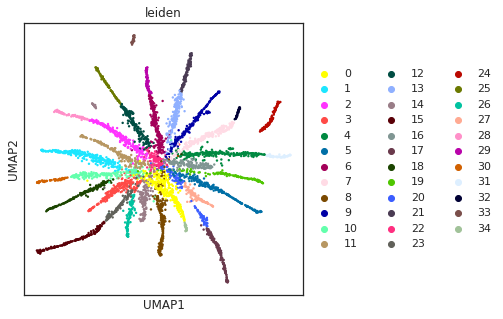

In [51]:
#sc.pl.umap(adata_s, color='leiden')

from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color='leiden')

In [52]:
# add the assigned strains

adata.obs['Strain'] = (adata.obs.index.map(bar_strain_dict).astype('category'))

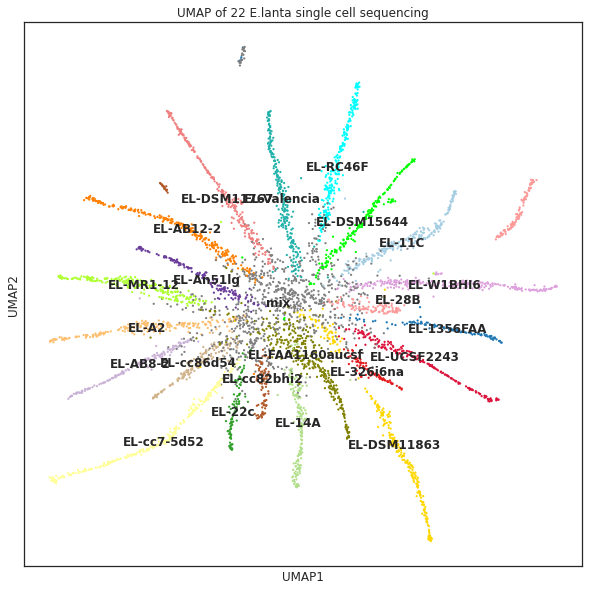

In [53]:
from matplotlib.pyplot import rc_context
import  collections
ordered_color_list =  list(collections.OrderedDict(sorted(cell_color_table.items())).values())

with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, 
               palette = ordered_color_list,
               color='Strain', 
               legend_loc='on data',
               title ='UMAP of 22 E.lanta single cell sequencing',
               size =20,
               save='elenta_umap.pdf')

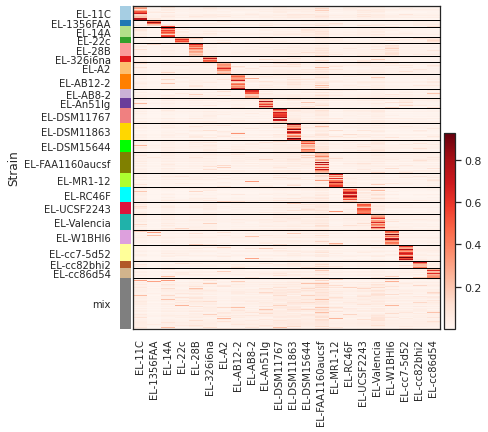

In [54]:
ax = sc.pl.heatmap(adata, 
                   adata.var_names, 
                   groupby='Strain', 
                   cmap='Reds', 
                   dendrogram=False, 
                   figsize=(6,6),
                   save='heatmap_elenta_2.pdf'
                  )

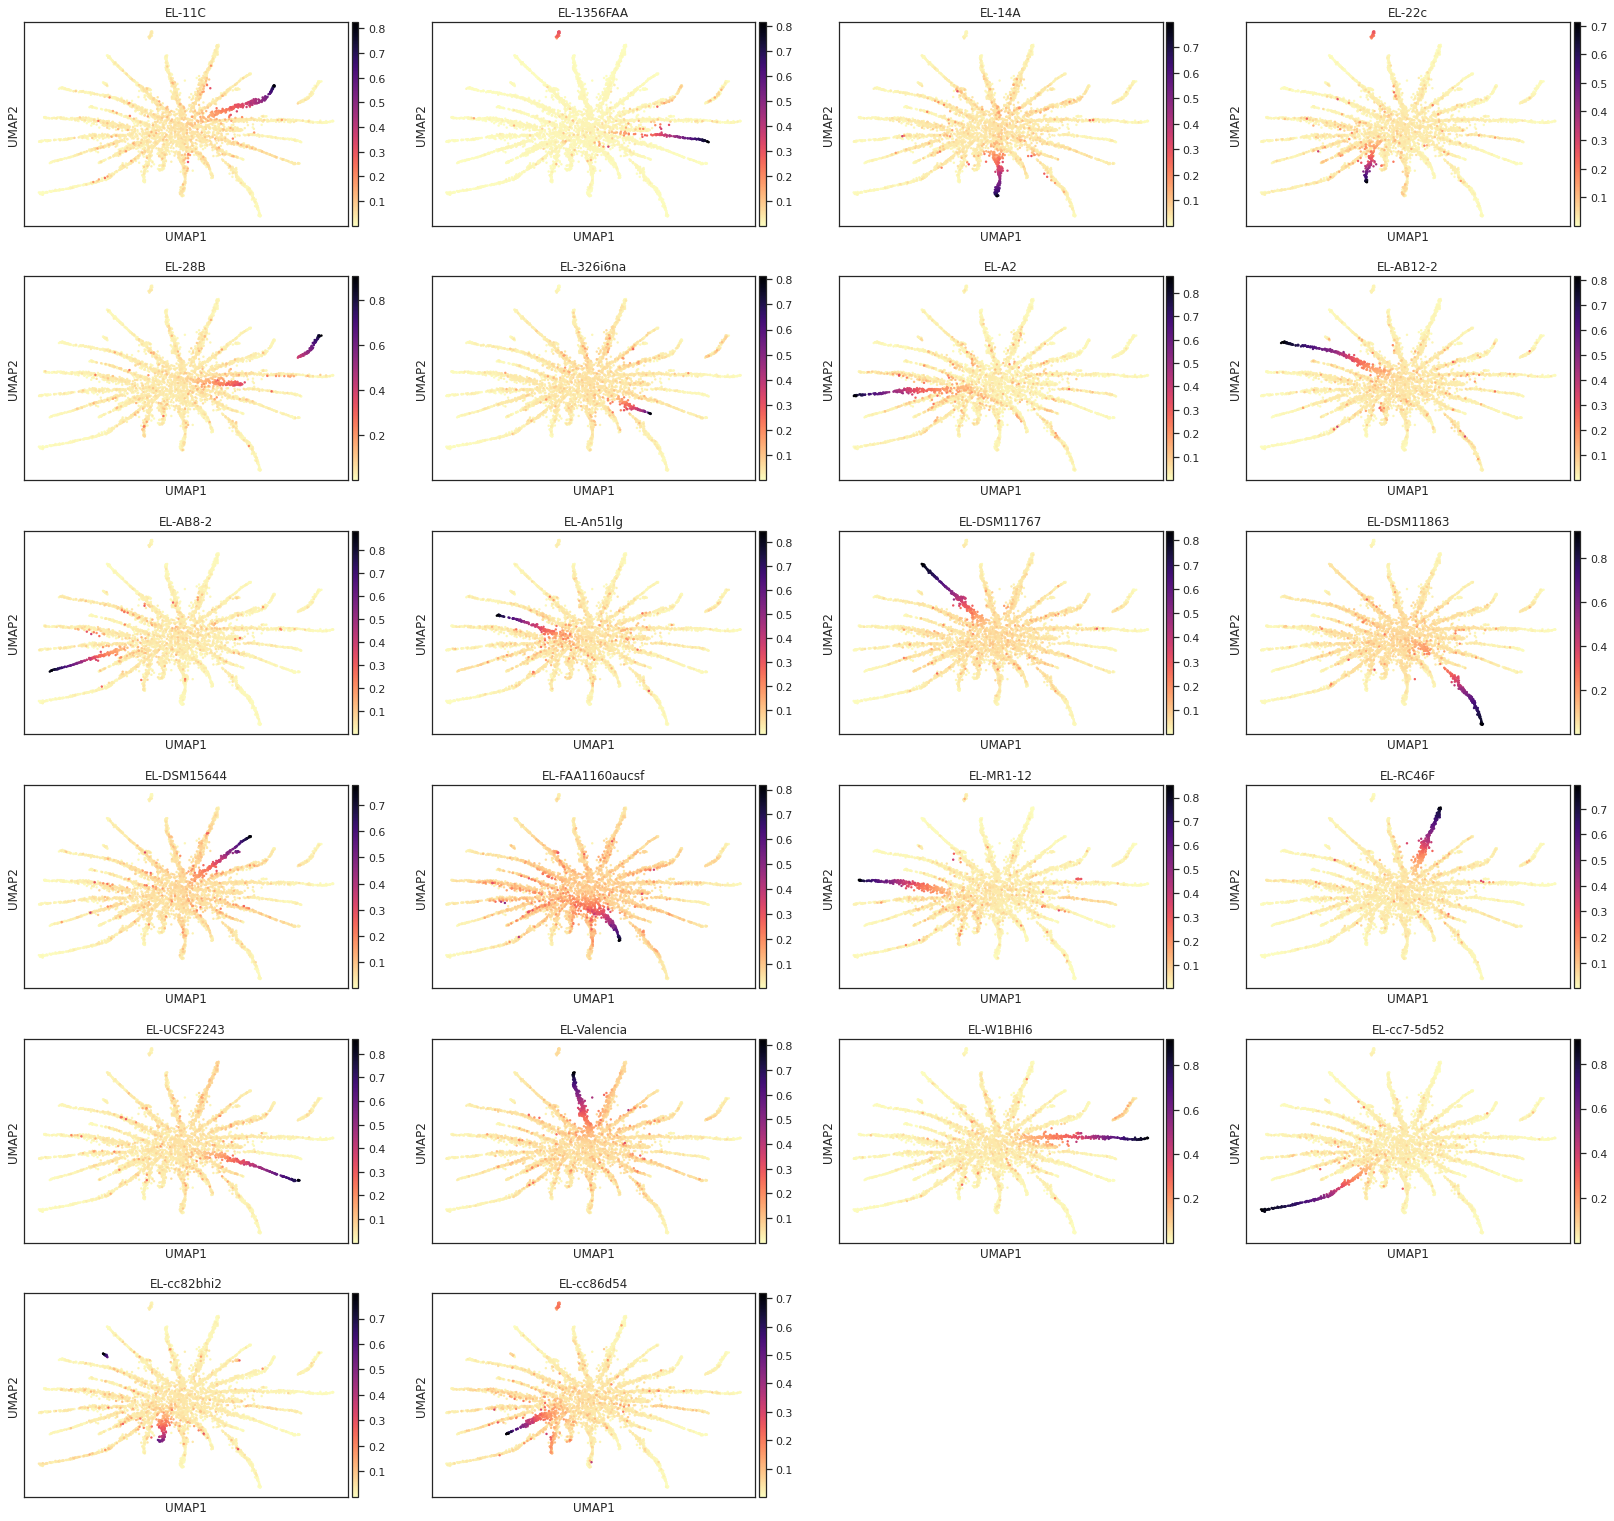

In [55]:
sc.pl.umap(adata, color=adata.var_names, color_map ="magma_r")

In [57]:
adata.write_h5ad(output_dir+'Elenta_Easi-seq_adata.h5ad')# save the adata